# Data preparation and processing

- Import libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
import pandas as pd

- Download dataset via kagglehub

In [2]:
# import kagglehub

# path = kagglehub.dataset_download("mitishaagarwal/patient")

# print("Path to dataset files:", path)

- Give a variable to store the path
- Read the CSV from the path
- Display the first 5 rows of data to test if successfully read the path

In [3]:
path = "/Users/soongjun/.cache/kagglehub/datasets/mitishaagarwal/patient/versions/3/dataset.csv"

data = pd.read_csv(path)

# data.head()

- Count the number of rows and columns
- Display the columns' names

In [4]:
print("Dataset shape:", data.shape, "\n")
print("Columns:", data.columns)

Dataset shape: (91713, 85) 

Columns: Index(['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
       'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache',
       'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache',
       'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_t

- Drop empty column by index
- Count the number of rows and columns to ensure the column is removed
- Display the new columns' names

In [5]:
data = data.drop(data.columns[-2], axis=1)
data = data.drop(columns = ["encounter_id", "hospital_id"])

print("Dataset shape:", data.shape, "\n")
print("Columns:", data.columns)

Dataset shape: (91713, 82) 

Columns: Index(['patient_id', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender',
       'height', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache',
       'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_

- Check the total columns with missing values

In [6]:
missing_values = data.isnull().mean() * 100

missing_summary = missing_values[missing_values > 0].sort_values(ascending=False)

print(f"Total columns with missing values: {missing_summary.shape[0]}")

Total columns with missing values: 74


- Set a random seed to ensure the randomness is consistent

In [7]:
np.random.seed(42)

- Separate the columns into numerical and categorical
- Handle missing values in numerical and categorical seperately
- Numerical will fill in missing values with medium values
- Categorical will fill in missing values with random choice from non-missing values
- Check if missing values is remained exist 

In [8]:
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns

for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        non_missing_values = data[col].dropna().unique()
        
        data[col] = data[col].apply(
            lambda x: np.random.choice(non_missing_values) if pd.isnull(x) else x
        )

missing_values_after_imputation = data.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_values_after_imputation}")

Total missing values after imputation: 0


- Check the data types to identify categorical columns
- Apply one-hot Encoding to to categorical columns
- Count the number of rows and columns in the data

In [9]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

print("Categorical Columns:", categorical_columns, "\n")
# print("Data after one-hot encoding:", "\n")
# print(df_encoded.head(), "\n")
print("Shape after encoding:", data.shape, "\n")

Categorical Columns: ['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem'] 

Shape after encoding: (91713, 113) 



- Identify the numerical columns
- Remove the target variables
- Normalise or scale numerial features with one-hot encoder

In [10]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_columns.remove('hospital_death')

scaler = StandardScaler()

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# print("Data after scaling:", "\n")
# print(data.head(), "\n")
print("Shape after scaling:", data.shape, "\n")

Shape after scaling: (91713, 113) 



- Separate the encoded data into X and y
- Split the data into training, validation, and testing set
- Data spliting ratio is 80:10:10
- Apply feature scaling after splitting

In [11]:
X = data.drop(columns=['hospital_death', 'patient_id'])
y = data['hospital_death']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train = scaler.fit_transform(X_train)

X_validate = scaler.transform(X_validate)

X_test = scaler.transform(X_test)

print("Training set shape:", X_train.shape, "\n")
print("Validation set shape:", X_validate.shape, "\n")
print("Test set shape:", X_test.shape, "\n")

Training set shape: (73370, 111) 

Validation set shape: (9171, 111) 

Test set shape: (9172, 111) 



# Model Architecture

- Import external Python file which is the model architecture
- Import libraries 

In [24]:
from hyperparameter_utils import sample_hyperparameters, train_and_evaluate
from model_utils import MLPModel
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn

- Set initial hyperparameters
- Call the model from external Python file
- Display the architecture of the model
- Apply Binary Cross Entropy Loss
- Apply Adam

In [13]:
input_dim = X_train.shape[1]
hidden_layers = [128, 64]
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 32
num_epochs = 50

model = MLPModel(input_dim=input_dim, hidden_layers=hidden_layers, dropout_rate=dropout_rate)

print(model)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

MLPModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=111, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


- Convert data into numpy array

In [14]:
y_validate = y_validate.to_numpy()

- Convert data into Tensor array
- Assign variables for train and validate dataset
- Feed the data into DataLoader

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_validate_tensor = torch.tensor(X_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(X_validate_tensor, y_validate_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

- Set number of epochs
- Train the model
- Validate the model
- Display the best validate loss

In [ ]:
best_validate_loss = float('inf')

train_losses = []
validate_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validate_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in validate_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            validate_loss += loss.item()
    validate_loss /= len(validate_loader)
    validate_losses.append(validate_loss)

    if validate_loss < best_validate_loss:
        best_validate_loss = validate_loss
        torch.save(model.state_dict(), 'MLP_model.pth')


    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")

Epoch 10/50, Train Loss: 0.1530, Validate Loss: 0.2209
Epoch 20/50, Train Loss: 0.1515, Validate Loss: 0.2253
Epoch 30/50, Train Loss: 0.1485, Validate Loss: 0.2300
Epoch 40/50, Train Loss: 0.1477, Validate Loss: 0.2344
Epoch 50/50, Train Loss: 0.1446, Validate Loss: 0.2299


- Visualise the training and validating loss over epochs

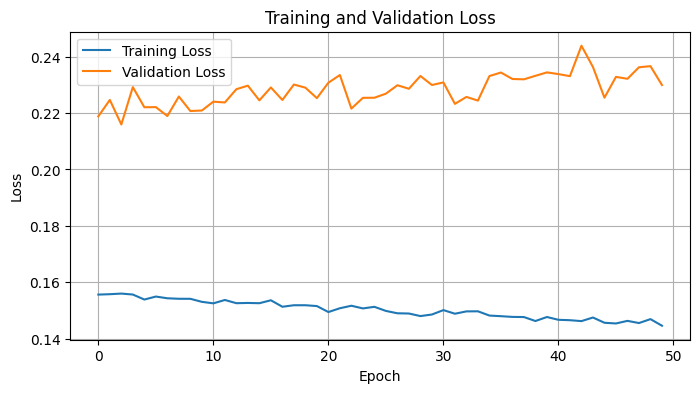

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(validate_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

- List of hyperparameter prepared to tune
- Set up number of trials to search the best hyperparameter

In [ ]:
param_space = {
    'hidden_layers': [[128, 64], [256, 128, 64], [64, 32]],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64]
}

num_trials = 5
results = []

for _ in range(num_trials):
    params = sample_hyperparameters(param_space)
    validate_loss, params = train_and_evaluate(
        params=params,
        model_class=MLPModel,
        input_dim=X_train.shape[1],
        train_dataset=train_dataset,
        validate_dataset=validate_dataset,
        criterion=criterion,
        num_epochs=num_epochs
    )
    results.append((validate_loss, params))

results = sorted(results, key=lambda x: x[0])
print("Best Configuration:", results[0])

Testing configuration: {'hidden_layers': [64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 16}
Validation Loss: 0.1974
Testing configuration: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16}
Validation Loss: 0.2220
Testing configuration: {'hidden_layers': [64, 32], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64}
Validation Loss: 0.2009
Testing configuration: {'hidden_layers': [64, 32], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16}
Validation Loss: 0.1970
Testing configuration: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64}
Validation Loss: 0.2066
Best Configuration: (0.19702505497813536, {'hidden_layers': [64, 32], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 16})


- Combine the training data and validate data into one dataset
- Extract the best hyperparameter tuning list
- Train the model again with the best parameters

In [ ]:
best_result = min(results, key=lambda x: x[0])
best_params = best_result[1]

X_train_combined = torch.cat((X_train_tensor, X_validate_tensor), dim=0)
y_train_combined = torch.cat((y_train_tensor, y_validate_tensor), dim=0)

combined_dataset = TensorDataset(X_train_combined, y_train_combined)
combined_loader = DataLoader(combined_dataset, batch_size=best_params['batch_size'], shuffle=True)

model = MLPModel(
    input_dim=X_train_combined.shape[1],
    hidden_layers=best_params['hidden_layers'],
    dropout_rate=best_params['dropout_rate']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])

num_epochs = num_epochs
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in combined_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(combined_loader)
    
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f})

Epoch 10/50, Train Loss: 0.1952, Validate Loss: 0.2299
Epoch 20/50, Train Loss: 0.1892, Validate Loss: 0.2299
Epoch 30/50, Train Loss: 0.1858, Validate Loss: 0.2299
Epoch 40/50, Train Loss: 0.1831, Validate Loss: 0.2299
Epoch 50/50, Train Loss: 0.1817, Validate Loss: 0.2299


- Save the model's parameters

In [ ]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully.")

- Load the model for testing phase
- Use the saved model to evaluate the testing dataset

In [ ]:
model = MLPModel(
    input_dim=X_train_combined.shape[1],
    hidden_layers=best_params['hidden_layers'],
    dropout_rate=best_params['dropout_rate']
)

model.load_state_dict(torch.load('model.pth'))
model.eval()
print("Model loaded successfully.", "\n")

with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor).item()

    # Convert predictions to binary labels (threshold = 0.5)
    test_predictions = (test_predictions > 0.5).float()

print(f"Test Loss: {test_loss:.4f}")